# Implement Positional Encoding In The Experimantal Model [Script 0]

Positional encoding from the script position_encoding_01.ipynb.  
Experimental model from the script trainFr_041A.ipynb.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from silence_tensorflow import silence_tensorflow
silence_tensorflow()  # silence TF warnings
import tensorflow as tf

from dataProcessing import load_file, insertTarget
from transformers import AutoTokenizer, TFCamembertForMaskedLM
from datetime import datetime
import copy
import sys

In [2]:
### instantiate the tokenizer
tokenizer = AutoTokenizer.from_pretrained("jplu/tf-camembert-base", do_lower_case=True)

### punctuation encoder
punctuation_enc = {
    'SPACE': 0,
    'PERIOD': 1,
}
outputDimension = len(punctuation_enc)

### Set Vocabulary Size, Also Specify The BERT Hidden Dimension
vocabSize = 32005
hiddenDimension = 768

### hyper-parameters
batchSize = 32
sequenceSize = 16
learningRate = 1e-5
trainLayerIndex = 0
numEpo = 5

listHyperNames = ['sequenceSize', 'batchSize', 'learningRate', 'trainLayerIndex', 'numEpo']
listHyperValues = [str(sequenceSize), str(batchSize), str(learningRate), str(trainLayerIndex), str(numEpo)]
time = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = 'ModelsExpScriber/{}/'.format(time)
# os.mkdir(save_path)

In [3]:
# ### FIRST VERSION

# def encodeDataTimeStamp(data, tokenizer, punctuation_enc):
#     """
#     Modified version of encodeData.
#     Takes in the dataset made of 4 columns separated by tab.
#     The columnds are the following:    word    punctuation    word begin    word end
    
#     Parameters:
#     ----------
#     data: list
#         List containing the lines of the input file.
#     tokenizer: 
#         The object used to tokenize the words.
#     punctuation_enc: dictionary
#         Encode name of punctuation (e.g., PERIOD) into integers (e.g., 1).
    
#     Returns:
#     ----------
#     X: list
#         Contains the tokens_ids.
#     Y: list
#         Contains the integers encoding the punctuation after each word in X.
#     """

#     X = []
#     XTimeStamps = []
#     Y = []
#     count = -1
#     for line in data:
#         count += 1
#         word, punc, wordBegin, wordEnd = line.split('\t')
#         wordBegin = float(wordBegin)
#         wordEnd = float(wordEnd)
#         tokens = tokenizer.tokenize(word)
#         x = tokenizer.convert_tokens_to_ids(tokens)
#         xTimeStamps = [[wordBegin, wordEnd]]
#         y = [punctuation_enc[punc]]
#         ### note that one word can be encoded in more than one token
#         if len(x) > 0:
#             if len(x) > 1:
#                 y += (len(x)-1) * [0]
#                 numTokens = len(x)
#                 for i in range(numTokens-1):
#                     xTimeStamps.append(xTimeStamps[0])
#                 # print("Line Index = ", count+1)
#             X += x
#             XTimeStamps += xTimeStamps
#             Y += y
#     return X, XTimeStamps, Y

In [4]:
## SECOND VERSION

def encodeDataTimeStamp(data, tokenizer, punctuation_enc):
    XTokensIds = []
    XTokensIdsBeg = []  
    XTokensIdsEnd = []  
    Y = []
    count = -1
    for line in data:
        count += 1
        word, punc, wordBeg, wordEnd = line.split("\t")
        tokens = tokenizer.tokenize(word)
        tokensIds = tokenizer.convert_tokens_to_ids(tokens)
        if len(tokensIds) > 0:
            ### note that one word can be encoded in more than one token
            if len(tokensIds) > 1:
                y = (len(tokensIds)-1) * [0]
                numTokens = len(tokensIds)
                for i in range(numTokens-1):
                    XTokensIdsBeg.append(float(wordBeg))
                    XTokensIdsEnd.append(float(wordEnd))
                Y += y
                # print("Line Index = ", count+1)
            XTokensIds += tokensIds
            XTokensIdsBeg.append(float(wordBeg))
            XTokensIdsEnd.append(float(wordEnd))
            Y += [punctuation_enc[punc]]
    return XTokensIds, XTokensIdsBeg, XTokensIdsEnd, Y

In [5]:
def correctTimeStamps(sequenceBegins, sequenceEnds, sequenceSize):
    """
    Apply two corrections to the time stamps:
        . wordEnd always larger than nextWordBegin.
        . Start time for the sequnce is zero.
    """

    ### CORRECTION 1
    ### Apply the correction to the time stamps.
    sequenceBeginsCorr = np.asarray(copy.deepcopy(sequenceBegins))
    sequenceEndsCorr = np.asarray(copy.deepcopy(sequenceEnds))
    for i in range(sequenceSize-1):
        wordBegin = sequenceBegins[i]
        wordEnd = sequenceEnds[i]
        nextWordBegin = sequenceBegins[i+1]
        nextWordEnd = sequenceEnds[i+1]
        ### i add an additional condition because sometimes wordEnd > nextWordBegin
        ### but not beacause of the start of a new sentence.
        if wordBegin != nextWordBegin and wordEnd != nextWordEnd:
            if wordEnd > nextWordBegin and abs(wordEnd - nextWordBegin) > 0.021:
                sequenceBeginsCorr[i+1:] += wordEnd
                sequenceEndsCorr[i+1:] += wordEnd
#         ### same as before but without the additional condition
#         if wordEnd > nextWordBegin:
#             sequenceBeginsCorr[i+1:] += wordEnd
#             sequenceEndsCorr[i+1:] += wordEnd
    ### CORRECTION 2
    ### Set beginning of first word in the sentence as time zero.
    sequenceBeginsCorr[:] -= sequenceBegins[0]
    sequenceEndsCorr[:] -= sequenceBegins[0]

    return list(sequenceBeginsCorr), list(sequenceEndsCorr)

In [6]:
def insertTargetTimeStamps(x, xBeg, xEnd, sequenceSize):
    
    X = []
    XBeg = []
    XEnd = []
    x_pad = x[-((sequenceSize-1)//2-1):]+x+x[:sequenceSize//2]
    xBeg_pad = xBeg[-((sequenceSize-1)//2-1):]+xBeg+xBeg[:sequenceSize//2]
    xEndPad = xEnd[-((sequenceSize-1)//2-1):]+xEnd+xEnd[:sequenceSize//2]

    for i in range(len(x_pad)-sequenceSize+2):
    # for i in range(1):

        ind = (sequenceSize-1)//2

        sequence = x_pad[i:i+sequenceSize-1]
        sequence.insert(ind, 0)
        X.append(sequence)

        sequenceBegs = xBeg_pad[i:i+sequenceSize-1]
        sequenceEnds = xEndPad[i:i+sequenceSize-1]
        
        # Apply corrections to the timestamps.
        sequenceBegsCorr, sequenceEndsCorr = correctTimeStamps(sequenceBegs, sequenceEnds, len(sequenceEnds))
        
        val = sequenceBegsCorr[ind-1]
        sequenceBegsCorr.insert(ind, val)
        
        val = sequenceEndsCorr[ind-1]
        sequenceEndsCorr.insert(ind, val)

        # Collect corrected data.
        XBeg.append(sequenceBegsCorr)
        XEnd.append(sequenceEndsCorr)

    return np.array(X), np.array(XBeg), np.array(XEnd)

In [7]:
### Get Training Dataset
print('\nProcessing Training Data ... ')

# load the file
trainDataName = 'outFile_03_100.txt'
dataTrain = load_file(trainDataName)

# encode data and insert target
XTrain, XTrainBeg, XTrainEnd, yTrain = encodeDataTimeStamp(dataTrain, tokenizer, punctuation_enc)
XTrainMod, XTrainBegMod, XTrainEndMod = insertTargetTimeStamps(XTrain, XTrainBeg, XTrainEnd, sequenceSize)
yTrain = np.asarray(yTrain)

XTrainAll = np.stack((XTrainMod, XTrainBegMod, XTrainEndMod), axis = 2)

### Build The Dataset
trainDataset = tf.data.Dataset.from_tensor_slices((XTrainAll, yTrain)).batch(batchSize)

print("\nTraining Dataset Tensor Shape = ", XTrainAll.shape)


Processing Training Data ... 

Training Dataset Tensor Shape =  (569, 16, 3)


In [8]:
print(XTrainAll.shape)
print(yTrain.shape)

(569, 16, 3)
(569,)


In [9]:
tokens = tokenizer.tokenize("-huit au trente donc là madame je fais la demande")
print(tokens)
tokens_ids = tokenizer.convert_tokens_to_ids(tokens)
print(tokens_ids)

['▁-', 'huit', '▁au', '▁trente', '▁donc', '▁là', '▁madame', '▁je', '▁fais', '▁la', '▁demande']
[67, 12351, 36, 4823, 145, 241, 10601, 50, 828, 13, 400]


In [10]:
print(XTrainMod.shape)
print(XTrainBegMod.shape)
print(XTrainEndMod.shape)
print(yTrain.shape)

(569, 16)
(569, 16)
(569, 16)
(569,)


In [11]:
print(XTrainMod[100, :])
print(XTrainBegMod[100, :])
print(XTrainEndMod[100, :])

[  53   14   42   75 2576   26 2024    0 3758   86 1122   11   59  604
  313   75]
[0.   1.33 1.41 1.64 1.92 1.92 1.92 1.92 1.92 2.57 2.72 2.72 2.72 3.1
 3.26 3.53]
[0.54 1.34 1.58 1.81 2.23 2.23 2.23 2.23 2.23 2.67 3.04 3.04 3.04 3.18
 3.47 3.71]


### Extraxct A Batch Of Data And Test The Positional Encoding

In [12]:
def positionalEncoding(sequence, depth):
    
    batchSize = sequence.shape[0]
    sequenceSize = sequence.shape[1]
    
    min_rate = 1/10000

    assert depth%2 == 0, "Depth must be even."
    angle_rate_exponents = np.linspace(0,1,depth//2)
    angle_rates = min_rate**(angle_rate_exponents)
    
    angle_rads = sequence[:, :, np.newaxis]*angle_rates[np.newaxis, np.newaxis, :]

    out = np.empty((batchSize, sequenceSize, depth))
    for i in range(batchSize):
        sines = np.sin(angle_rads[i, :, :])
        cosines = np.cos(angle_rads[i, :, :])
        arr = np.reshape(np.vstack((sines, cosines)).ravel('F'), (sequenceSize, depth), order='F')
        out[i, :, :] = arr
    
    return out

In [13]:
inputExample, targetExample = next(iter(trainDataset))
tokensTensor = tf.cast(inputExample[:, :, 0], dtype="int64")
beginsTensor = inputExample[:, :, 1]
endsTensor = inputExample[:, :, 2]
print(beginsTensor.shape)

# # This is just to do a check
# positions = np.arange(sequenceSize) 
# timeStamps = np.tile(positions, (batchSize,1))
# print(timeStamps.shape)
# beginsTensor = timeStamps

# apply positional encoding
depth = 512
inputBeginsTensor = positionalEncoding(beginsTensor, depth)
inputEndsTensor = positionalEncoding(endsTensor, depth)

(32, 16)


In [14]:
print(beginsTensor[0, :])

tf.Tensor(
[0.   0.11 0.11 0.11 0.51 0.57 0.86 0.86 1.1  1.24 1.49 1.64 1.83 1.95
 2.27 2.39], shape=(16,), dtype=float64)


In [15]:
print(beginsTensor[30, :])

tf.Tensor(
[0.   0.43 1.59 3.57 4.4  4.4  4.4  4.4  4.6  4.97 5.2  5.36 5.51 5.65
 5.8  6.17], shape=(16,), dtype=float64)


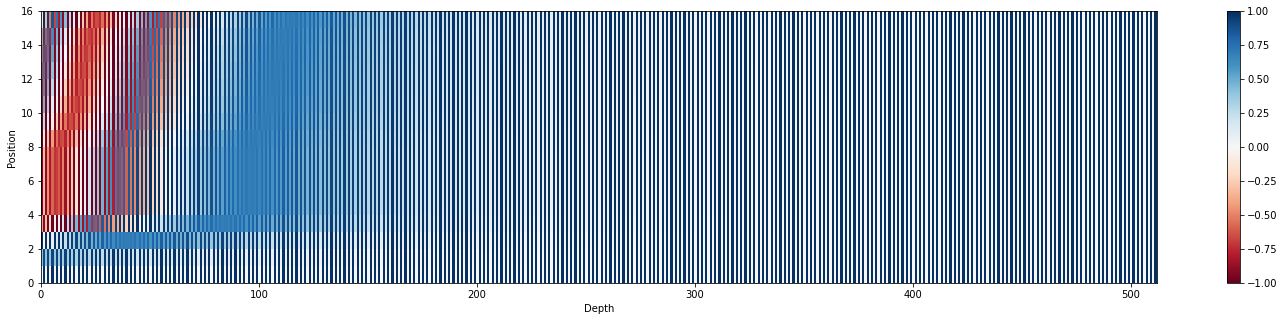

In [16]:
plt.figure(figsize=(25,5))
plt.pcolormesh(inputBeginsTensor[30, :, :], 
               # Use a diverging colormap so it's clear where zero is.
               cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('Position')
plt.xlabel('Depth')
plt.colorbar()
plt.show()

In [17]:
print(endsTensor[0, ])

tf.Tensor(
[0.07 0.37 0.37 0.37 0.52 0.86 1.04 1.04 1.19 1.43 1.52 1.73 1.9  2.28
 2.28 2.75], shape=(16,), dtype=float64)


In [18]:
print(endsTensor[30, ])

tf.Tensor(
[0.29 0.63 2.22 3.68 4.51 4.51 4.51 4.51 4.91 5.15 5.28 5.39 5.61 5.73
 6.19 6.19], shape=(16,), dtype=float64)


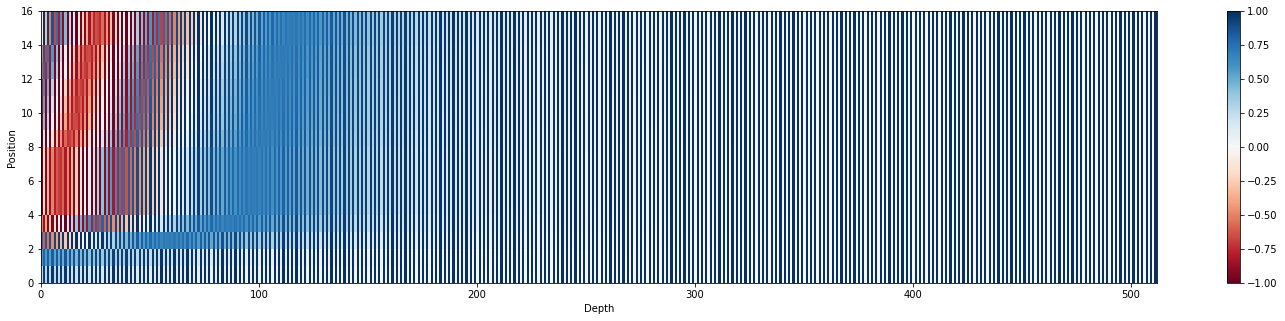

In [19]:
plt.figure(figsize=(25,5))
plt.pcolormesh(inputEndsTensor[30, :, :], 
               # Use a diverging colormap so it's clear where zero is.
               cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('Position')
plt.xlabel('Depth')
plt.colorbar()
plt.show()

### Compute Positioanl Encoding Given By The Concatenation Of Begin And End Time Stamps

In [20]:
inputExample = next(iter(trainDataset))
tokensTensor = tf.cast(inputExample[0][:, :, 0], dtype="int64")
beginsTensor = inputExample[0][:, :, 1]
endsTensor = inputExample[0][:, :, 2]

depth = 384
inputBeginsTensor = positionalEncoding(beginsTensor, depth)
inputEndsTensor = positionalEncoding(endsTensor, depth)
inputPosTensor = np.concatenate((inputBeginsTensor, inputEndsTensor), axis=2)
print(inputPosTensor.shape)

(32, 16, 768)


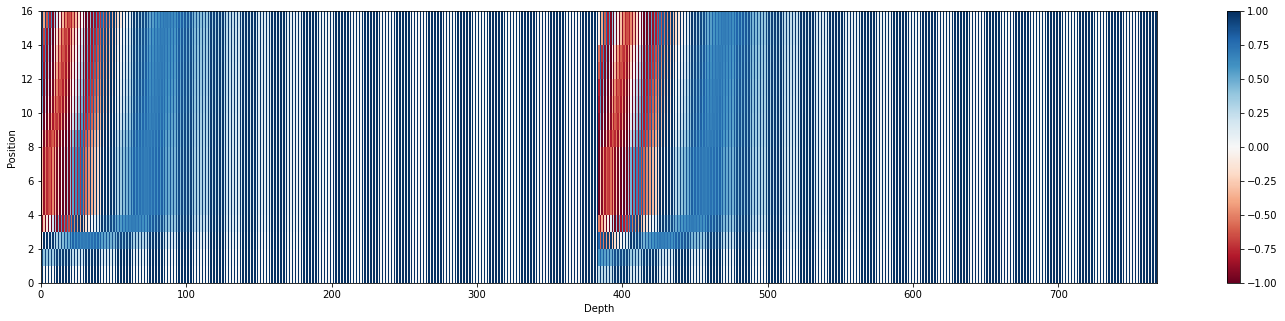

In [21]:
plt.figure(figsize=(25,5))
plt.pcolormesh(inputPosTensor[30, :, :], 
               # Use a diverging colormap so it's clear where zero is.
               cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0, inputPosTensor.shape[2]])
plt.ylabel('Position')
plt.xlabel('Depth')
plt.colorbar()
plt.show()

### Build The Experimental Model And Test It

In [22]:
### Build The Experimental Model
print('\nBulding the Model ... ')

inpA = tf.keras.Input(shape=(sequenceSize), dtype='int32')
inpB = tf.keras.Input(shape=(sequenceSize, hiddenDimension), batch_size=batchSize, dtype='float32')
x = TFCamembertForMaskedLM.from_pretrained("jplu/tf-camembert-base")(inpA, custom_embeds=inpB)[0]
x = tf.keras.layers.Reshape((sequenceSize*vocabSize,))(x)
out = tf.keras.layers.Dense(len(punctuation_enc))(x)

model = tf.keras.Model(inputs=[inpA, inpB], outputs=[out])

# define the loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
def loss(model, x, custom_embeds, y):
    y_ = model([x, custom_embeds])
    return loss_object(y_true=y, y_pred=y_)

# func to calculate the gradients
def grad(model, inputs, custom_embeds, targets, trainLayerIndex):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, custom_embeds, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables[trainLayerIndex:])

# define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate)


Bulding the Model ... 


In [23]:
## Take The Model For A Spin

inputExample = next(iter(trainDataset))
tokensTensor = tf.cast(inputExample[0][:, :, 0], dtype="int64")
beginsTensor = inputExample[0][:, :, 1]
endsTensor = inputExample[0][:, :, 2]

# get positional encoding tensor for time stamps
depth = hiddenDimension//2
inputBeginsTensor = positionalEncoding(beginsTensor, depth)
inputEndsTensor = positionalEncoding(endsTensor, depth)
inputPosTensor = tf.convert_to_tensor(np.concatenate((inputBeginsTensor, inputEndsTensor), axis=2))

print(type(tokensTensor))
print(tokensTensor.shape)
print("")
print(type(inputPosTensor))
print(inputPosTensor.shape)

output = model([tokensTensor, inputPosTensor])

print("")
print(type(output))
print(output.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 16)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 16, 768)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 2)


### Training Loop

In [24]:
print("\nExperiment Folder: ", time)
print("\nHyperparameters:")
print('vocabSize = ', vocabSize)
print('sequenceSize = ', sequenceSize)
print('batchSize = ', batchSize)
print('leaRat = ', learningRate)
print('Train Layer Index = ', trainLayerIndex)
print('numEpo = ', numEpo)

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

train_loss_results = []
train_accuracy_results = []

checkpoint_path = save_path + "cp-{epoch:03d}.ckpt"

print("\nTraining the Model ... ")
for epoch in range(1, numEpo+1):

    # training loop
    for x, y in trainDataset:
        
        tokensTensor = tf.cast(x[0][:, :, 0], dtype="int64")
        beginsTensor = x[0][:, :, 1]
        endsTensor = x[0][:, :, 2]

        # get positional encoding tensor for time stamps
        depth = hiddenDimension//2
        inputBeginsTensor = positionalEncoding(beginsTensor, depth)
        inputEndsTensor = positionalEncoding(endsTensor, depth)
        inputPosTensor = tf.convert_to_tensor(np.concatenate((inputBeginsTensor, inputEndsTensor), axis=2))

        # optimize the model
        loss_value, grads = grad(model, tokensTensor, inputPosTensor, y, trainLayerIndex)
        optimizer.apply_gradients(zip(grads, model.trainable_variables[trainLayerIndex:]))

        # track progress
        epoch_loss_avg.update_state(loss_value)
        epoch_accuracy.update_state(y, model([tokensTensor, inputPosTensor]))

    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print("\nEpoch {:03d}: (Training)   Loss: {:.3f}, Accuracy: {:.3%}".format(epoch, epoch_loss_avg.result(), epoch_accuracy.result()))

    # # save model if new min for train loss is found
    tmpTrain = epoch_loss_avg.result().numpy()
    model.save_weights(checkpoint_path.format(epoch=epoch))

    epoch_loss_avg.reset_states()
    epoch_accuracy.reset_states()


Experiment Folder:  20200711_184557

Hyperparameters:
vocabSize =  32005
sequenceSize =  16
batchSize =  32
leaRat =  1e-05
Train Layer Index =  0
numEpo =  5

Training the Model ... 


InvalidArgumentError: Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/